# UW-Madison GI Tract Image Segmentation

## Inference

In [163]:
#!/usr/bin/env python

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.options.plotting.backend = "plotly"
from tqdm.notebook import tqdm
tqdm.pandas()
import numpy as np
import os
import re
import cv2
from plotly.offline import init_notebook_mode
from glob import glob

import tensorflow as tf

# Visualization Imports
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm; tqdm.pandas();
import plotly.express as px
import seaborn as sns
from PIL import Image, ImageEnhance
import matplotlib; print(f"\t\t– MATPLOTLIB VERSION: {matplotlib.__version__}");
from matplotlib import animation, rc; rc('animation', html='jshtml')
from matplotlib.colors import LinearSegmentedColormap
import plotly
import PIL
import cv2
import math

# Import Tensorflow and Keras
from tensorflow import keras
import tensorflow as tf
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

from keras.models import load_model


		– MATPLOTLIB VERSION: 3.5.2


In [164]:
%cd 'hpc_train_files'

[Errno 2] No such file or directory: 'hpc_train_files'
/Users/viktor/Documents/BA/GIT/HealthyOrganTracker/hpc_train_files


In [165]:
from utility import rle_encode, rle_decode, open_gray16
from config import CFG
from dataloader import DataGenerator
from loss import dice_coef, iou_coef, dice_loss, bce_dice_loss, dice_coef2
from datapreparation import extract_metadata, remove_faulties

## Config ⚙️


In [166]:
BASE_PATH = 'input/uw-madison-gi-tract-image-segmentation/'
TRAIN_DIR =  BASE_PATH +'train'
TRAIN_CSV =  BASE_PATH +'train.csv'
STYE = "multilabel"
DEBUG = True

"""
Backbones available: 
        'efficientnetb0'
        'efficientnetb1'
        'efficientnetb2'
        'efficientnetb3'
        'efficientnetb4'
        'efficientnetb5'
        'efficientnetb6'
        'efficientnetb7'
        'inceptionresnetv2'
        'inceptionv3'
        'resnet50'
        'resnext50'
        'resnext101'
        'seresnext50'
        'seresnext101'
        'densenet121'
        'densenet201'
        """

"\nBackbones available: \n        'efficientnetb0'\n        'efficientnetb1'\n        'efficientnetb2'\n        'efficientnetb3'\n        'efficientnetb4'\n        'efficientnetb5'\n        'efficientnetb6'\n        'efficientnetb7'\n        'inceptionresnetv2'\n        'inceptionv3'\n        'resnet50'\n        'resnext50'\n        'resnext101'\n        'seresnext50'\n        'seresnext101'\n        'densenet121'\n        'densenet201'\n        "

In [167]:
df = pd.read_csv(TRAIN_CSV)
#df = df.sample(n=90, random_state=1)

In [168]:
cfg = CFG(
    backbone            = 'efficientnetb0',
    img_dims            = (256,256,3),
    model               = 'U-Net',
    batch_size          = 16, 
    epochs              = 1, 
    kaggle              = False, 
    use_fold_csv        = True,
    semi3d_data         = False,
    remove_faulty_cases = True,
    use_crop_data       = False)

In [169]:
# Custom color map in matplotlib
def CustomCmap(rgb_color):

    r1,g1,b1 = rgb_color

    cdict = {'red': ((0, r1, r1),
                   (1, r1, r1)),
           'green': ((0, g1, g1),
                    (1, g1, g1)),
           'blue': ((0, b1, b1),
                   (1, b1, b1))}

    cmap = LinearSegmentedColormap('custom_cmap', cdict)
    return cmap


## Load Dataframe with crop infos

In [170]:
df_train = extract_metadata(df, TRAIN_DIR, channels=3, stride=2)
df_train.sample(5)

Frame merged. Shape: (38496, 21)
Remove faulty cases: True
Sucess. Shape: (38208, 21)


,id,large_bowel,small_bowel,stomach,case,day,slice,path,width,height,...,pixel_y,count,path00,path01,path02,image_paths,rs,re,cs,ce
24371,case116_day0_slice_0116,55127 10 55486 12 55700 6 55845 15 56059 8 562...,35072 7 35429 40 35787 45 36145 53 36504 60 36...,,116,0,116,input/uw-madison-gi-tract-image-segmentation/t...,360,310,...,1.50,2,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,[input/uw-madison-gi-tract-image-segmentation/...,73,10000,0,334
25694,case119_day21_slice_0031,,,,119,21,31,input/uw-madison-gi-tract-image-segmentation/t...,266,266,...,1.50,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,[input/uw-madison-gi-tract-image-segmentation/...,19,10000,0,266
12203,case54_day30_slice_0124,,,,54,30,124,input/uw-madison-gi-tract-image-segmentation/t...,266,266,...,1.50,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,[input/uw-madison-gi-tract-image-segmentation/...,57,10000,0,257
37234,case154_day13_slice_0035,,,,154,13,35,input/uw-madison-gi-tract-image-segmentation/t...,266,266,...,1.50,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,[input/uw-madison-gi-tract-image-segmentation/...,47,10000,0,254
31765,case136_day27_slice_0118,49431 4 49788 8 50144 13 50500 17 50858 19 512...,46262 8 46621 12 46936 7 46981 15 47292 12 473...,,136,27,118,input/uw-madison-gi-tract-image-segmentation/t...,360,310,...,1.50,2,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,[input/uw-madison-gi-tract-image-segmentation/...,81,10000,0,302


## Generate Original Masks

In [171]:
IMAGE_SHAPE = SEG_SHAPE = (224,224)

def make_seg_mask(row, output_dir, resize_to, resize=False):
    """"""
    _slice_shape = (row.height, row.width)
    counter  = 0
    
    if not pd.isna(row.large_bowel):
        lb_mask = rle_decode(row.large_bowel, _slice_shape)
    else:
        lb_mask = np.zeros(_slice_shape)
        counter +=1
        
    if not pd.isna(row.small_bowel):
        sb_mask = rle_decode(row.small_bowel, _slice_shape)
    else:
        sb_mask = np.zeros(_slice_shape)
        counter +=1
        
    if not pd.isna(row.stomach):
        st_mask = rle_decode(row.stomach, _slice_shape)
    else:
        st_mask = np.zeros(_slice_shape)
        counter +=1
    
    mask_arr = np.stack([lb_mask, sb_mask, st_mask], axis=-1)
    
    if resize:
        mask_arr = cv2.resize(mask_arr, resize_to, interpolation=cv2.INTER_NEAREST).astype(np.uint8)
            
    mask_path = os.path.join(output_dir, f"{row.id}_mask.png")
    if counter != 3:
        cv2.imwrite(mask_path, mask_arr)
        
    return mask_path

## Plot Masks Helper


In [172]:

def plot_masks_chronologic(imgs, masks, ids, alpha=1):
    
    slices = [i.split("_")[-1] for i in ids]
    
    # Plot
    fig, axs = plt.subplots(2, 5, figsize=(23, 11))
    axs = axs.flatten()
    
    for k, (img, mask) in enumerate(zip(imgs, masks)):

        # Change pixels - when 1 make True, when 0 make NA
        mask = np.ma.masked_where(mask == 0, mask)

        # Split the channels
        mask_largeB = mask[:, :, 0]
        mask_smallB = mask[:, :, 1]
        mask_stomach = mask[:, :, 2]
        
        title = f"{k+1}. Slice {slices[k]}"
        axs[k].set_title(title, fontsize = 16, 
                         color = my_colors[-1], weight='bold')

        axs[k].imshow(img, cmap="gist_gray")
        axs[k].axis("off")
        axs[k].imshow(mask_largeB, interpolation='none', cmap=CMAP1, alpha=alpha)
        axs[k].imshow(mask_smallB, interpolation='none', cmap=CMAP2, alpha=alpha)
        axs[k].imshow(mask_stomach, interpolation='none', cmap=CMAP3, alpha=alpha)
        axs[k].axis("off")
    
    axs[0].legend(legend_colors, labels, loc=2)
    plt.tight_layout()
    plt.show()

In [173]:
df_train = pd.read_csv("df_train.csv")
df_train.fillna('', inplace=True)
df_train

,Unnamed: 0,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,count,path00,path01,path02,image_paths,rs,re,cs,ce
0,0,case123_day20_slice_0001,,,,input/uw-madison-gi-tract-image-segmentation/t...,123,20,1,266,266,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,['input/uw-madison-gi-tract-image-segmentation...,20,10000,0,266
1,1,case123_day20_slice_0002,,,,input/uw-madison-gi-tract-image-segmentation/t...,123,20,2,266,266,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,['input/uw-madison-gi-tract-image-segmentation...,20,10000,0,266
2,2,case123_day20_slice_0003,,,,input/uw-madison-gi-tract-image-segmentation/t...,123,20,3,266,266,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,['input/uw-madison-gi-tract-image-segmentation...,20,10000,0,266
3,3,case123_day20_slice_0004,,,,input/uw-madison-gi-tract-image-segmentation/t...,123,20,4,266,266,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,['input/uw-madison-gi-tract-image-segmentation...,20,10000,0,266
4,4,case123_day20_slice_0005,,,,input/uw-madison-gi-tract-image-segmentation/t...,123,20,5,266,266,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,['input/uw-madison-gi-tract-image-segmentation...,20,10000,0,266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38491,38491,case30_day0_slice_0140,,,,input/uw-madison-gi-tract-image-segmentation/t...,30,0,140,266,266,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,['input/uw-madison-gi-tract-image-segmentation...,1,10000,0,266
38492,38492,case30_day0_slice_0141,,,,input/uw-madison-gi-tract-image-segmentation/t...,30,0,141,266,266,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,['input/uw-madison-gi-tract-image-segmentation...,1,10000,0,266
38493,38493,case30_day0_slice_0142,,,,input/uw-madison-gi-tract-image-segmentation/t...,30,0,142,266,266,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,['input/uw-madison-gi-tract-image-segmentation...,1,10000,0,266
38494,38494,case30_day0_slice_0143,,,,input/uw-madison-gi-tract-image-segmentation/t...,30,0,143,266,266,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,['input/uw-madison-gi-tract-image-segmentation...,1,10000,0,266


In [174]:
DEBUG = False
if DEBUG:
    df_train["multilabel_mask_path"] = df_train.progress_apply(lambda _row: make_seg_mask(_row, outputdir, resize_to=SEG_SHAPE, resize=False), axis=1)
    df_train.to_csv("df_train_with_mask_paths.csv", index=False)
else:
    df_train = pd.read_csv("df_train_with_mask_paths.csv")
    df_train.fillna('', inplace=True)



In [175]:
df_train

,Unnamed: 0,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,...,count,path00,path01,path02,image_paths,rs,re,cs,ce,multilabel_mask_path
0,0,case123_day20_slice_0001,,,,input/uw-madison-gi-tract-image-segmentation/t...,123,20,1,266,...,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,['input/uw-madison-gi-tract-image-segmentation...,20,10000,0,266,input/uw-madison-gi-tract-image-segmentation/m...
1,1,case123_day20_slice_0002,,,,input/uw-madison-gi-tract-image-segmentation/t...,123,20,2,266,...,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,['input/uw-madison-gi-tract-image-segmentation...,20,10000,0,266,input/uw-madison-gi-tract-image-segmentation/m...
2,2,case123_day20_slice_0003,,,,input/uw-madison-gi-tract-image-segmentation/t...,123,20,3,266,...,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,['input/uw-madison-gi-tract-image-segmentation...,20,10000,0,266,input/uw-madison-gi-tract-image-segmentation/m...
3,3,case123_day20_slice_0004,,,,input/uw-madison-gi-tract-image-segmentation/t...,123,20,4,266,...,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,['input/uw-madison-gi-tract-image-segmentation...,20,10000,0,266,input/uw-madison-gi-tract-image-segmentation/m...
4,4,case123_day20_slice_0005,,,,input/uw-madison-gi-tract-image-segmentation/t...,123,20,5,266,...,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,['input/uw-madison-gi-tract-image-segmentation...,20,10000,0,266,input/uw-madison-gi-tract-image-segmentation/m...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38491,38491,case30_day0_slice_0140,,,,input/uw-madison-gi-tract-image-segmentation/t...,30,0,140,266,...,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,['input/uw-madison-gi-tract-image-segmentation...,1,10000,0,266,input/uw-madison-gi-tract-image-segmentation/m...
38492,38492,case30_day0_slice_0141,,,,input/uw-madison-gi-tract-image-segmentation/t...,30,0,141,266,...,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,['input/uw-madison-gi-tract-image-segmentation...,1,10000,0,266,input/uw-madison-gi-tract-image-segmentation/m...
38493,38493,case30_day0_slice_0142,,,,input/uw-madison-gi-tract-image-segmentation/t...,30,0,142,266,...,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,['input/uw-madison-gi-tract-image-segmentation...,1,10000,0,266,input/uw-madison-gi-tract-image-segmentation/m...
38494,38494,case30_day0_slice_0143,,,,input/uw-madison-gi-tract-image-segmentation/t...,30,0,143,266,...,0,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,input/uw-madison-gi-tract-image-segmentation/t...,['input/uw-madison-gi-tract-image-segmentation...,1,10000,0,266,input/uw-madison-gi-tract-image-segmentation/m...


## Visualiize

In [176]:
mask_colors = [(1.0, 0.7, 0.1), (1.0, 0.5, 1.0), (1.0, 0.22, 0.099)]
legend_colors = [Rectangle((0,0),1,1, color=color) for color in mask_colors]
labels = ["Dickdarm", "Dünndarm", "Magen"]

CMAP1 = CustomCmap(mask_colors[0])
CMAP2 = CustomCmap(mask_colors[1])
CMAP3 = CustomCmap(mask_colors[2])

In [177]:
def mask_from_segmentation(segmentation, shape):
    '''Returns the mask corresponding to the inputed segmentation.
    segmentation: a list of start points and lengths in this order
    max_shape: the shape to be taken by the mask
    return:: a 2D mask'''

    # Get a list of numbers from the initial segmentation
    segm = np.asarray(segmentation.split(), dtype=int)

    # Get start point and length between points
    start_point = segm[0::2] - 1
    length_point = segm[1::2]

    # Compute the location of each endpoint
    end_point = start_point + length_point

    # Create an empty list mask the size of the original image
    # take onl
    case_mask = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    # Change pixels from 0 to 1 that are within the segmentation
    for start, end in zip(start_point, end_point):
        case_mask[start:end] = 1

    case_mask = case_mask.reshape((shape[0], shape[1]))
    
    return case_mask

In [178]:
def get_id_mask(ID, train, verbose=False):
    '''Returns a mask for each case ID. If no segmentation was found, the mask will be empty
    - meaning formed by only 0
    ID: the case ID from the train.csv file
    verbose: True if we want any prints
    return: segmentation mask'''

    # ~~~ Get the data ~~~
    # Get the portion of dataframe where we have ONLY the speciffied ID
    ID_data = train[train["id"]==ID].reset_index(drop=True)

    # Split the dataframe into 3 series of observations
    # each for one speciffic class - "large_bowel", "small_bowel", "stomach"
    observations = [ID_data[k] for k in ["large_bowel", "small_bowel", "stomach"]]
    # ~~~ Create the mask ~~~
    # Get the maximum height out of all observations
    # if max == 0 then no class has a segmentation
    # otherwise we keep the length of the mask
    max_height = ID_data['height'].values[0]
    max_width = ID_data['width'].values[0]
    
    # Get shape of the image
    # 3 channels of color/classes
    shape = (max_height, max_width, 3)
    
    if ID_data['count'].values[0] == 0:
        return np.zeros(shape, dtype=np.uint8)

    # Create an empty mask with the shape of the image
    mask = np.zeros(shape, dtype=np.uint8)

    # If there is at least 1 segmentation found in the group of 3 classes
    if max_height != 0:
        for k, location in enumerate(["large_bowel", "small_bowel", "stomach"]):
            observation = ID_data[location].values[0]
            segmentation = observation

            # If a segmentation is found
            # Append a new channel to the mask
            if pd.isnull(segmentation) == False:
                mask[..., k] = mask_from_segmentation(segmentation, shape)

            
    return mask

def get_pred_mask(ID, train):
    ID_data = train[train["id"]==ID].reset_index(drop=True)
    height = ID_data['height'].values[0]
    width = ID_data['width'].values[0]
    shape = (height,width,3)
    masks = np.zeros(shape, dtype=np.uint8)
    
    for k, location in enumerate(["large_bowel_dice_coef_predicted", "small_bowel_dice_coef_predicted", "stomach_dice_coef_predicted"]):
        observation = ID_data[location].values[0]
        if(not isinstance(observation, str)):
            continue
            
        mask = rle_decode(observation, shape=(height,width,1))
        masks[..., k] = np.squeeze(mask)
        
    return masks

In [223]:
# Thanks to Darueb Schettler and his notebook: 
# https://www.kaggle.com/code/dschettler8845/uwmgit-deeplabv3-w-se-aspp-tf-e2e-pipeline

def plot_original_mask(img, mask, alpha=0.4):

    # Change pixels - when 1 make True, when 0 make NA
    mask = np.ma.masked_where(mask == 0, mask)

    # Split the channels
    mask_largeB = mask[:, :, 0]
    mask_smallB = mask[:, :, 1]
    mask_stomach = mask[:, :, 2]


    # Plot the 2 images (Original and with Mask)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

    # Original
    ax1.set_title("Orginalbild")
    ax1.imshow(img)
    ax1.axis("off")

    # With Mask
    ax2.set_title("Segmentiertes Bild")
    ax2.imshow(img)
    ax2.imshow(mask_largeB, interpolation='none', cmap=CMAP1, alpha=alpha)
    ax2.imshow(mask_smallB, interpolation='none', cmap=CMAP2, alpha=alpha)
    ax2.imshow(mask_stomach, interpolation='none', cmap=CMAP3, alpha=alpha)
    ax2.legend(legend_colors, labels)
    ax2.axis("off")
    
#     fig.savefig('foo.png', dpi=500)
    plt.show()
def get_overlay(img, mask, _alpha=0.999, _beta=0.45, _gamma=0):
    
    # Normalize to be between 0-1 (float32)
    img = (img/img.max()).astype(np.float32)

    
    mask_rgb=mask.astype(np.float32)
    
    # overlay
    seg_overlay = cv2.addWeighted(src1=img, alpha=_alpha, 
                                  src2=mask_rgb, beta=_beta, gamma=_gamma)
    return seg_overlay

def get_miss_overlay(gt_mask, pred_mask, _alpha=0.9, _beta=0.25, _gamma=0):
    
    # Make mask RGB and float32
    miss_rgb = np.zeros((*pred_mask.shape[:2],3), dtype=np.float32)
        
    miss_rgb = np.where((gt_mask==pred_mask)&(gt_mask!=0.0), (0.0,0.8,0.0), (0.0,0.0,0.0))
    miss_rgb = np.where((gt_mask!=pred_mask), (0.8,0.0,0.0), miss_rgb)
        
    return miss_rgb

def plot_preds(img, pred_mask, gt_mask):
    gt_overlay = get_overlay(img, gt_mask)
    pred_overlay = get_overlay(img, pred_mask)
    
    plt.figure(figsize=(20,12))
    
    for i, (_desc, _img) in enumerate(zip(["Original", "Vorhersage", "Ground-Truth"], [img, pred_overlay, gt_overlay])):        
        plt.subplot(1,4,i+1)
        plt.imshow(_img)
        plt.title(f"{_desc} Image", fontweight="bold")        
        plt.axis(False)
        
        if i in [1,2]:
            handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
            labels = ["Dickdarm", "Dünndarm", "Magen"]
            plt.legend(handles,labels)
    plt.tight_layout()
    plt.show()

def get_meta_info_from_model_path(file):
    regexBone = 'None' if not re.search("BB_(\w+)_D",file) else re.search("BB_(\w+)_D",file).group(1) 
    regexDim = 'None' if not re.search("DIM_\((\d+),",file) else int(re.search("DIM_\((\d+),",file).group(1) )
    threeDim = 'None' if not re.search("SEMI3D_([aA-zZ]{4,5})_",file) else re.search("SEMI3D_([aA-zZ]{4,5})_",file).group(1) 
    regexCrop = 'None' if not re.search("CROPDATA_([aA-zZ]{4,5})_",file) else re.search("CROPDATA_([aA-zZ]{4,5})_",file).group(1) 
    regexBatch = 'None' if not re.search("BATCH_(\d+)_",file) else int(re.search("BATCH_(\d+)_",file).group(1) )
    regexEpochs = 'None' if not re.search("EPOCHS_(\d+)_",file) else int(re.search("EPOCHS_(\d+)_",file).group(1))
    regexFold = 'None' if not re.search("Fold_(\d).",file) else int(re.search("Fold_(\d).",file).group(1))
    regexFaulties = 'None' if not re.search("FAULTIES_([aA-zZ]{4,5})_",file) else re.search("FAULTIES_([aA-zZ]{4,5})_",file).group(1)

    return regexBone, regexDim, threeDim, regexCrop, regexBatch, regexEpochs, regexFold, regexFaulties

In [263]:
for result in glob(os.path.join("../tensorboard_logs/efb2", "**", "*val_results.csv"), recursive=True):
    print(result)

../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_False_CROPDATA_True_FAULTIES_False_BATCH_16_EPOCHS_50_FOLD_3.h5_23082022-2113_FOLD_3/model.h5_val_results.csv
../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_True_CROPDATA_False_FAULTIES_True_BATCH_16_EPOCHS_50_FOLD_3.h5_23082022-2114_FOLD_3/model.h5_val_results.csv
../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_False_CROPDATA_False_FAULTIES_True_BATCH_16_EPOCHS_50_FOLD_3.h5_23082022-2111_FOLD_3/model.h5_val_results.csv
../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_True_CROPDATA_True_FAULTIES_False_BATCH_16_EPOCHS_50_FOLD_3.h5_23082022-2121_FOLD_3/model.h5_val_results.csv
../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_False_CROPDATA_True_FAULTIES_True_BATCH_16_EPOCHS_50_FOLD_3.h5_23082022-2114_FOLD_3/model.h5_val_results.csv
../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_False_CROPDATA_

In [372]:
def evaluate_models(path):
    eval_ = pd.DataFrame(columns=['Encoder','Größe', '2.5D', 'Crop' , 'Bereinigt', 'Batch Size', 'Epochen', 'Dickdarm', 'Dünndarm', 'Magen', 'Schnitt'])
    for result in glob(os.path.join(path, "**", "*val_results.csv"), recursive=True):
        print(result)
        df_val = pd.read_csv(result)

        df_val['large_bowel_dice_coef'] = df_val['large_bowel_dice_coef'].fillna(0)
        df_val['small_bowel_dice_coef'] = df_val['small_bowel_dice_coef'].fillna(0)
        df_val['stomach_dice_coef'] = df_val['stomach_dice_coef'].fillna(0)
        
        regexBone, regexDim, threeDim, regexCrop, regexBatch, regexEpochs, regexFold, regexFaulties = get_meta_info_from_model_path(result)

        mean_stomach_score = df_val['stomach_dice_coef'].mean()
        mean_sb_score = df_val['small_bowel_dice_coef'].mean()
        mean_lb_score = df_val['large_bowel_dice_coef'].mean()
        
        mean_total = (mean_stomach_score + mean_sb_score + mean_lb_score) / 3

        eval_ = eval_.append({'Encoder':regexBone, 'Größe':regexDim, '2.5D':threeDim, 'Crop':regexCrop,'Bereinigt':regexFaulties ,'Batch Size':regexBatch, 'Epochen':regexEpochs, 'Dickdarm':mean_lb_score, 'Dünndarm':mean_sb_score, 'Magen':mean_stomach_score, 'Schnitt':mean_total}, ignore_index=True)

    return eval_.sort_values(by=['Schnitt'], ascending=False)

def print_history_latex(history_df):

    print(history_df.to_latex(index=False , float_format=lambda x: '{:.4f}'.format(x)))

# Evaluation

In [373]:
ev = evaluate_models('../tensorboard_logs/efb2')

../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_False_CROPDATA_True_FAULTIES_False_BATCH_16_EPOCHS_50_FOLD_3.h5_23082022-2113_FOLD_3/model.h5_val_results.csv
../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_True_CROPDATA_False_FAULTIES_True_BATCH_16_EPOCHS_50_FOLD_3.h5_23082022-2114_FOLD_3/model.h5_val_results.csv
../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_False_CROPDATA_False_FAULTIES_True_BATCH_16_EPOCHS_50_FOLD_3.h5_23082022-2111_FOLD_3/model.h5_val_results.csv
../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_True_CROPDATA_True_FAULTIES_False_BATCH_16_EPOCHS_50_FOLD_3.h5_23082022-2121_FOLD_3/model.h5_val_results.csv
../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_False_CROPDATA_True_FAULTIES_True_BATCH_16_EPOCHS_50_FOLD_3.h5_23082022-2114_FOLD_3/model.h5_val_results.csv
../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_False_CROPDATA_

In [374]:
ev

,Encoder,Größe,2.5D,Crop,Bereinigt,Batch Size,Epochen,Dickdarm,Dünndarm,Magen,Schnitt
1,efficientnetb2,256,True,False,True,16,50,0.299893,0.234285,0.193071,0.242416
7,efficientnetb2,256,True,False,False,16,50,0.297259,0.231369,0.19235,0.240326
6,efficientnetb2,256,True,True,True,16,50,0.296739,0.228184,0.189205,0.238043
5,efficientnetb2,256,False,False,False,16,50,0.295082,0.226513,0.191385,0.23766
3,efficientnetb2,256,True,True,False,16,50,0.293221,0.224673,0.188229,0.235374
0,efficientnetb2,256,False,True,False,16,50,0.291492,0.222186,0.187223,0.233634
4,efficientnetb2,256,False,True,True,16,50,0.292758,0.220798,0.186862,0.233472
2,efficientnetb2,256,False,False,True,16,50,0.289781,0.217903,0.186506,0.231397


In [306]:
def load_evaluation(path):
    model_fff = pd.read_csv("../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_False_CROPDATA_False_FAULTIES_False_BATCH_16_EPOCHS_50_FOLD_3.h5_23082022-2106_FOLD_3/model.h5_val_results.csv")
    model_fff['dice_mean'] = model_fff[['large_bowel_dice_coef','small_bowel_dice_coef','stomach_dice_coef']].mean(axis=1)
    return model_fff

\begin{tabular}{lllllllllll}
\toprule
       Encoder & Größe &  2.5D &  Crop & Bereinigt & Batch Size & Epochen & Dickdarm & Dünndarm &  Magen & Schnitt \\
\midrule
efficientnetb2 &   256 &  True & False &      True &         16 &      50 &   0.8758 &   0.8400 & 0.8999 &  0.8719 \\
efficientnetb2 &   256 &  True & False &     False &         16 &      50 &   0.8742 &   0.8310 & 0.8976 &  0.8676 \\
efficientnetb2 &   256 & False & False &     False &         16 &      50 &   0.8611 &   0.8106 & 0.8817 &  0.8512 \\
efficientnetb2 &   256 &  True &  True &      True &         16 &      50 &   0.8599 &   0.8119 & 0.8773 &  0.8497 \\
efficientnetb2 &   256 &  True &  True &     False &         16 &      50 &   0.8476 &   0.7962 & 0.8784 &  0.8407 \\
efficientnetb2 &   256 & False &  True &     False &         16 &      50 &   0.8380 &   0.7811 & 0.8626 &  0.8272 \\
efficientnetb2 &   256 & False &  True &      True &         16 &      50 &   0.8453 &   0.7828 & 0.8530 &  0.8270 \\
efficient

In [354]:
model_ttt = pd.read_csv("../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_True_CROPDATA_True_FAULTIES_True_BATCH_16_EPOCHS_50_FOLD_3.h5_23082022-2114_FOLD_3/model.h5_val_results.csv")

model_fff = pd.read_csv("../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_False_CROPDATA_False_FAULTIES_False_BATCH_16_EPOCHS_50_FOLD_3.h5_23082022-2106_FOLD_3/model.h5_val_results.csv")
model_fff['dice_mean'] = model_fff[['large_bowel_dice_coef','small_bowel_dice_coef','stomach_dice_coef']].mean(axis=1)

In [370]:
df_val = pd.read_csv("../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_True_CROPDATA_True_FAULTIES_True_BATCH_16_EPOCHS_50_FOLD_3.h5_23082022-2114_FOLD_3/model.h5_val_results.csv")
# Fill NaN's
df_val['large_bowel_dice_coef'] = df_val['large_bowel_dice_coef'].fillna(1)
df_val['small_bowel_dice_coef'] = df_val['small_bowel_dice_coef'].fillna(1)
df_val['stomach_dice_coef'] = df_val['stomach_dice_coef'].fillna(1)

In [371]:
df_val

,index,Unnamed: 0,id,large_bowel,small_bowel,stomach,case,day,slice,path,...,cs,ce,multilabel_mask_path,fold,large_bowel_dice_coef,small_bowel_dice_coef,stomach_dice_coef,stomach_predicted,large_bowel_predicted,small_bowel_predicted
0,3024,3024,case18_day19_slice_0001,NaN,NaN,NaN,18,19,1,input/uw-madison-gi-tract-image-segmentation/t...,...,0.0,295.0,input/uw-madison-gi-tract-image-segmentation/m...,3,1.0,1.0,1.0,NaN,NaN,NaN
1,3025,3025,case18_day19_slice_0002,NaN,NaN,NaN,18,19,2,input/uw-madison-gi-tract-image-segmentation/t...,...,0.0,295.0,input/uw-madison-gi-tract-image-segmentation/m...,3,1.0,1.0,1.0,NaN,NaN,NaN
2,3026,3026,case18_day19_slice_0003,NaN,NaN,NaN,18,19,3,input/uw-madison-gi-tract-image-segmentation/t...,...,0.0,295.0,input/uw-madison-gi-tract-image-segmentation/m...,3,1.0,1.0,1.0,NaN,NaN,NaN
3,3027,3027,case18_day19_slice_0004,NaN,NaN,NaN,18,19,4,input/uw-madison-gi-tract-image-segmentation/t...,...,0.0,295.0,input/uw-madison-gi-tract-image-segmentation/m...,3,1.0,1.0,1.0,NaN,NaN,NaN
4,3028,3028,case18_day19_slice_0005,NaN,NaN,NaN,18,19,5,input/uw-madison-gi-tract-image-segmentation/t...,...,0.0,295.0,input/uw-madison-gi-tract-image-segmentation/m...,3,1.0,1.0,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7947,38203,38203,case156_day11_slice_0140,NaN,NaN,NaN,156,11,140,input/uw-madison-gi-tract-image-segmentation/t...,...,0.0,266.0,input/uw-madison-gi-tract-image-segmentation/m...,3,1.0,1.0,1.0,NaN,NaN,NaN
7948,38204,38204,case156_day11_slice_0141,NaN,NaN,NaN,156,11,141,input/uw-madison-gi-tract-image-segmentation/t...,...,0.0,266.0,input/uw-madison-gi-tract-image-segmentation/m...,3,1.0,1.0,1.0,NaN,NaN,NaN
7949,38205,38205,case156_day11_slice_0142,NaN,NaN,NaN,156,11,142,input/uw-madison-gi-tract-image-segmentation/t...,...,0.0,266.0,input/uw-madison-gi-tract-image-segmentation/m...,3,1.0,1.0,1.0,NaN,NaN,NaN
7950,38206,38206,case156_day11_slice_0143,NaN,NaN,NaN,156,11,143,input/uw-madison-gi-tract-image-segmentation/t...,...,0.0,266.0,input/uw-madison-gi-tract-image-segmentation/m...,3,1.0,1.0,1.0,NaN,NaN,NaN


In [367]:
diff = model_fff['dice_mean'] - model_ttt['dice_mean']
diff.dropna().nsmallest(10)

1894   -0.940031
1896   -0.936909
1895   -0.936472
1897   -0.934211
1746   -0.888933
1747   -0.875726
6905   -0.857057
1750   -0.854020
1898   -0.849084
1748   -0.843374
Name: dice_mean, dtype: float64

In [362]:
diff = model_ttt['dice_mean'] - model_fff['dice_mean']
diff.dropna().nsmallest(10)

4283   -0.917976
4817   -0.868684
4775   -0.861633
2691   -0.848722
3719   -0.845705
5203   -0.817669
5202   -0.791353
2985   -0.723137
1000   -0.661780
1001   -0.656073
Name: dice_mean, dtype: float64

In [368]:
model_ttt.iloc[1894]

index                                                                 8886
Unnamed: 0                                                            8886
id                                                 case40_day17_slice_0119
large_bowel              17965 8 18225 25 18488 30 18752 35 19015 41 19...
small_bowel              20419 4 20683 10 20948 14 21213 18 21479 20 21...
stomach                                                                NaN
case                                                                    40
day                                                                     17
slice                                                                  119
path                     input/uw-madison-gi-tract-image-segmentation/t...
width                                                                  266
height                                                                 266
pixel_x                                                                1.5
pixel_y                  

In [369]:
model_fff.loc[1894]

index                                                                 8886
Unnamed: 0                                                            8886
id                                                 case40_day17_slice_0119
large_bowel              17965 8 18225 25 18488 30 18752 35 19015 41 19...
small_bowel              20419 4 20683 10 20948 14 21213 18 21479 20 21...
stomach                                                                NaN
case                                                                    40
day                                                                     17
slice                                                                  119
path                     input/uw-madison-gi-tract-image-segmentation/t...
width                                                                  266
height                                                                 266
pixel_x                                                                1.5
pixel_y                  

case88_day36_slice_0122
0.00034730584593485
(310, 360, 3)


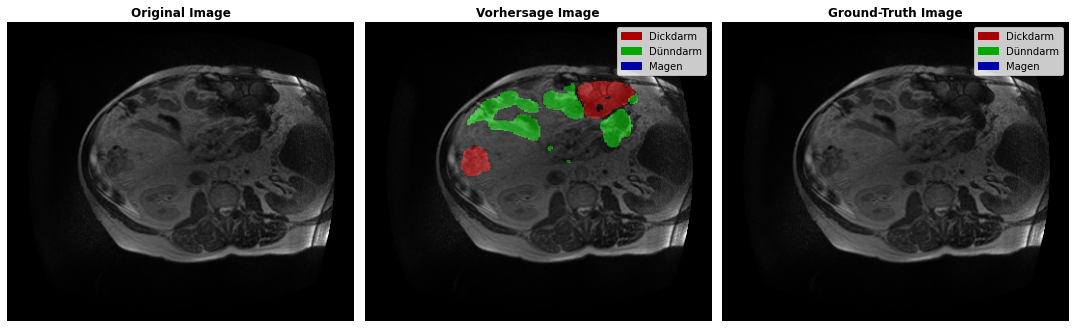

case88_day36_slice_0121
0.00038830627454439996
(310, 360, 3)


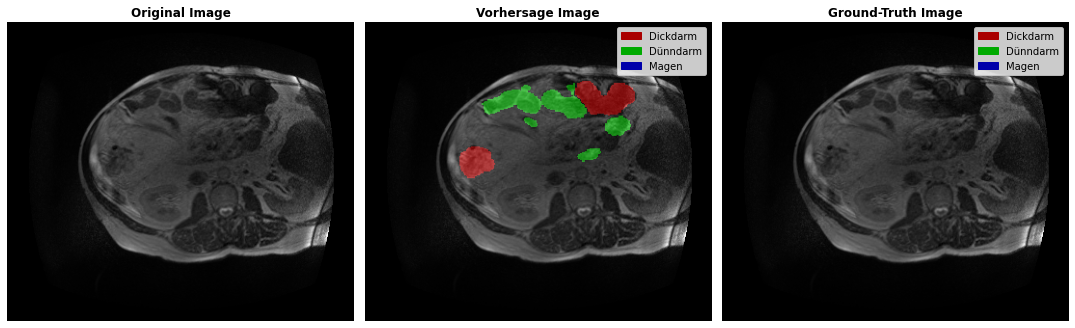

case88_day0_slice_0121
0.00039664153155165
(310, 360, 3)


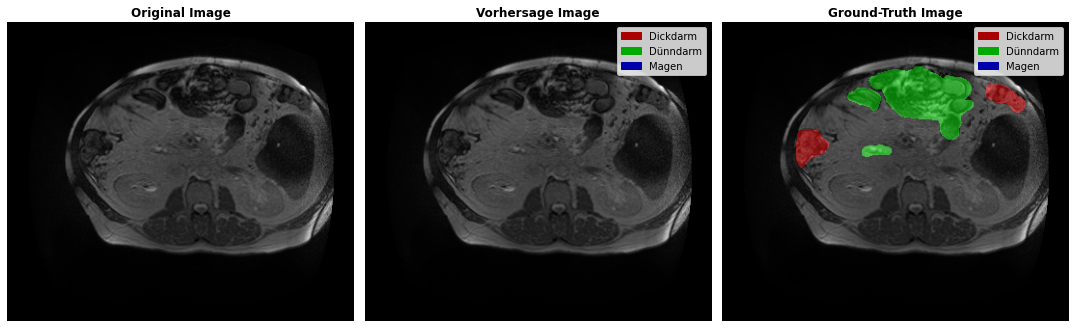

case88_day0_slice_0122
0.00040339653787665
(310, 360, 3)


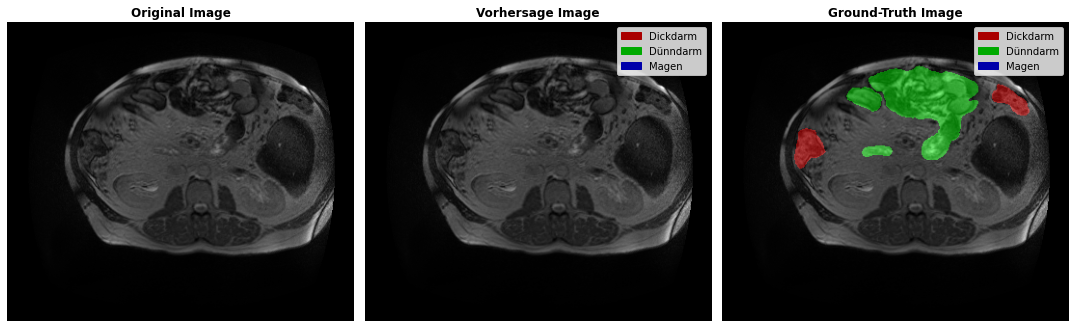

case40_day17_slice_0122
0.00044451512803785
(266, 266, 3)


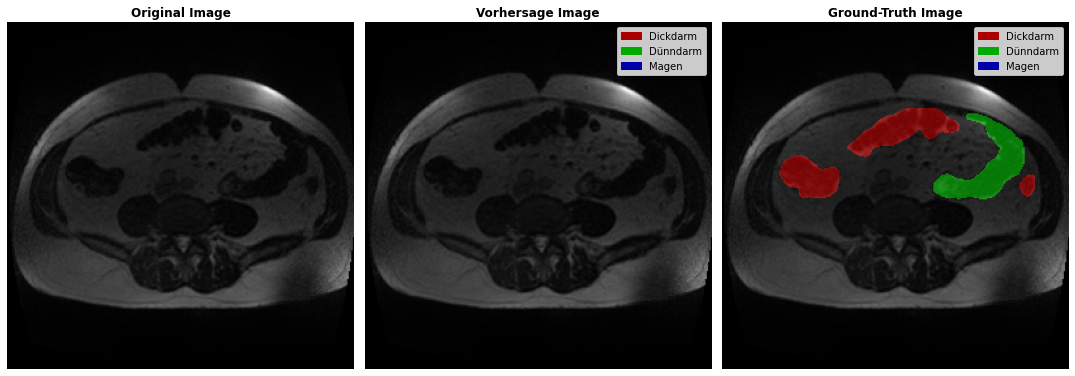

case40_day17_slice_0123
0.00045005779247724996
(266, 266, 3)


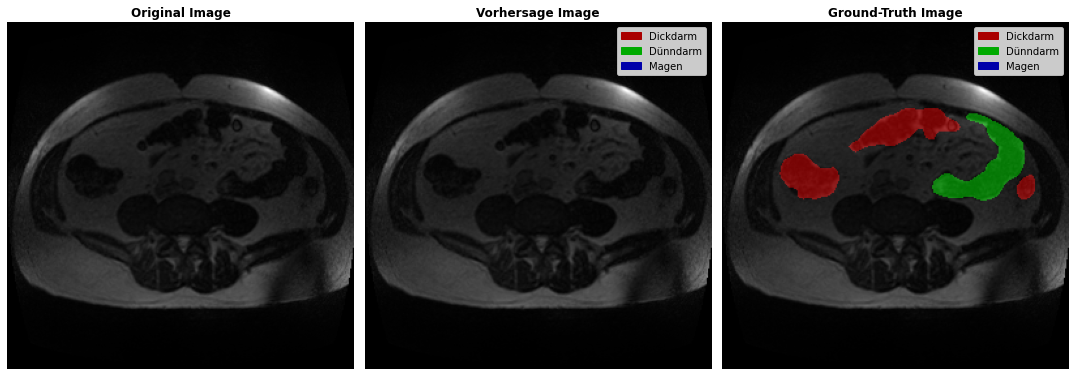

case40_day17_slice_0121
0.00045136132393955005
(266, 266, 3)


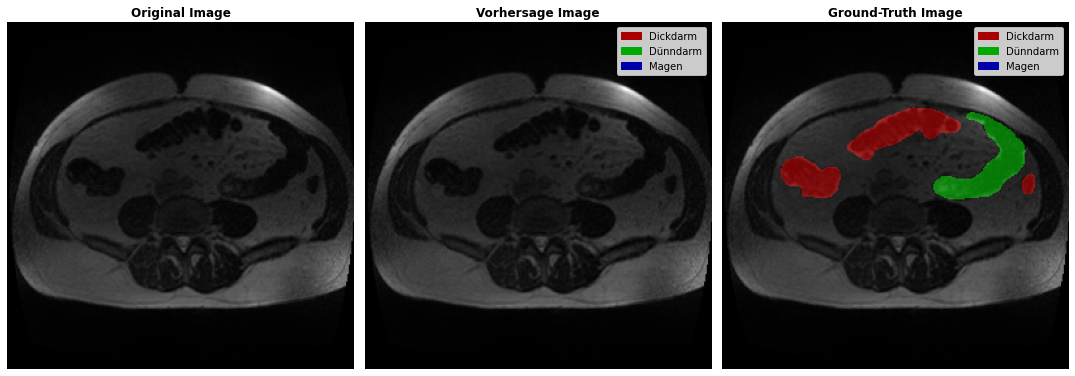

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


case49_day13_slice_0109
0.00045463854621625
(310, 360, 3)


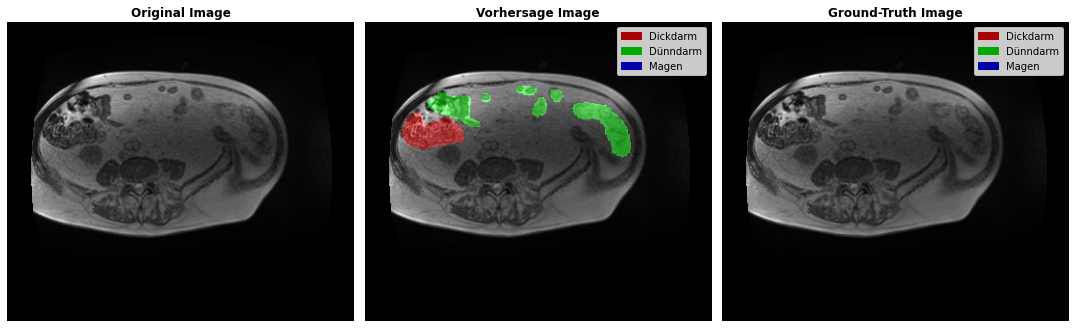

case40_day17_slice_0120
0.00046538434980895004
(266, 266, 3)


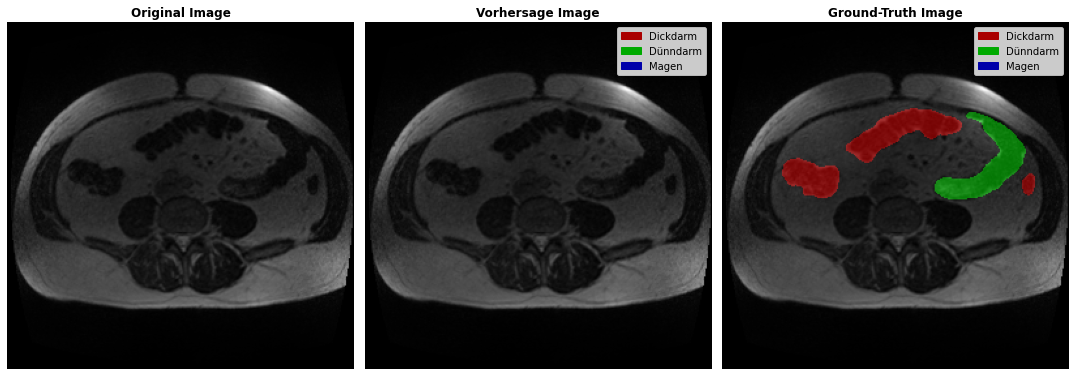

case40_day0_slice_0120
0.00049754540668795
(266, 266, 3)


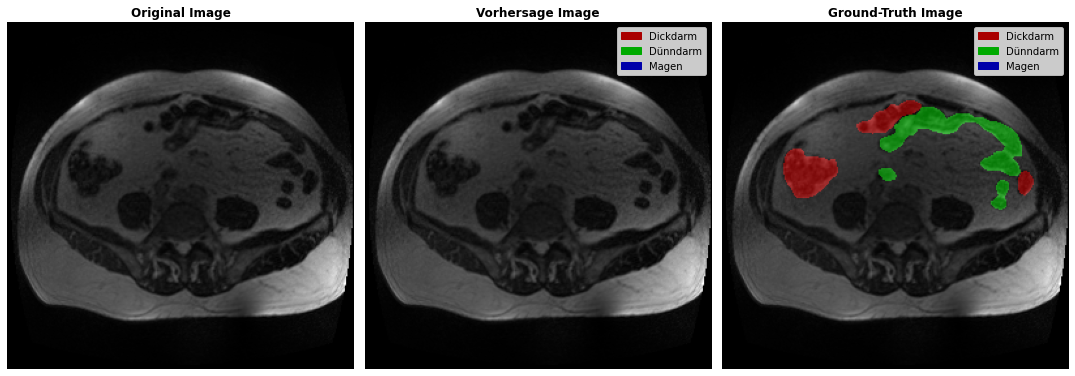

In [349]:
data = pd.read_csv("../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_False_CROPDATA_False_FAULTIES_False_BATCH_16_EPOCHS_50_FOLD_3.h5_23082022-2106_FOLD_3/model.h5_val_results.csv")
df_val['dice_mean'] = df_val[['large_bowel_dice_coef','small_bowel_dice_coef','stomach_dice_coef']].mean(axis=1)

smallest =  df_val[df_val['dice_mean'] < 1].nsmallest(10, 'dice_mean')
for i in range(len(smallest)):
    ID = smallest['id'].values[i]
    
    print(ID)
    print(df_val[df_val['id'] == ID]['dice_mean'].values[0])
    
    img_path = df_val[df_val['id'] == ID]['path'].values[0]
    
    img = open_gray16(img_path, normalize=True, to_rgb=True)
    img = ((img-img.min())/(img.max()-img.min())).astype(np.float32)
    
    mask = get_id_mask(ID,df_train, verbose=False)
        
    pred = get_pred_mask(ID, df_val)
    
    print(pred.shape)
    #plot_original_mask(img, mask, alpha=0.6)
    plot_preds(img, pred, mask)

case88_day36_slice_0122
0.00034730584593485
(310, 360, 3)


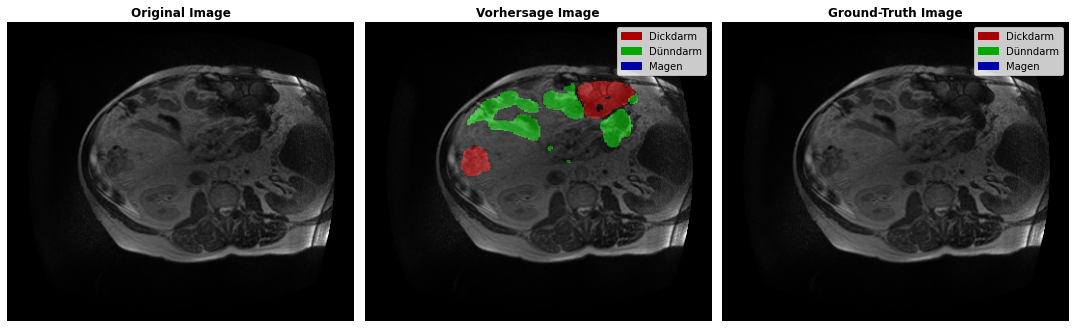

case88_day36_slice_0121
0.00038830627454439996
(310, 360, 3)


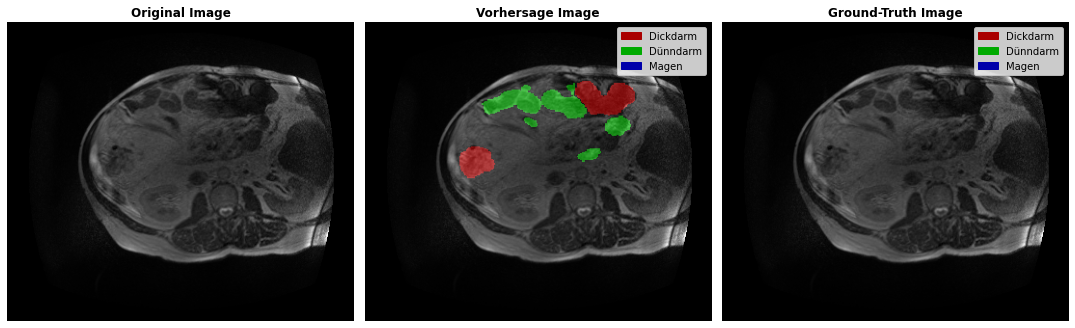

case88_day0_slice_0121
0.00039664153155165
(310, 360, 3)


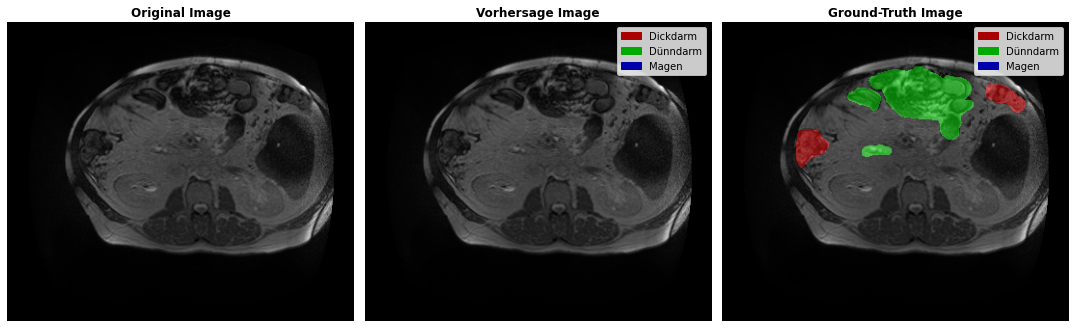

case88_day0_slice_0122
0.00040339653787665
(310, 360, 3)


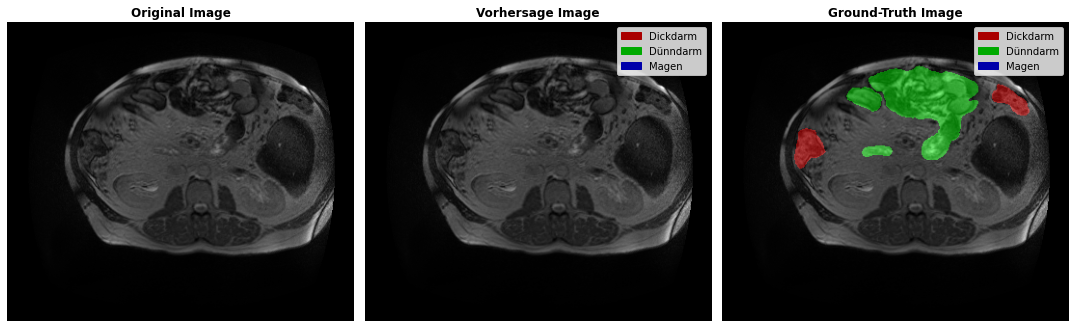

case40_day17_slice_0122
0.00044451512803785
(266, 266, 3)


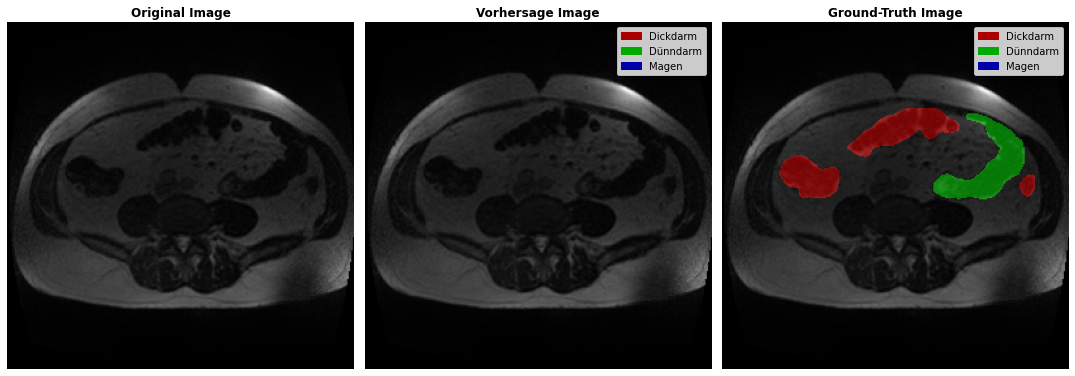

case40_day17_slice_0123
0.00045005779247724996
(266, 266, 3)


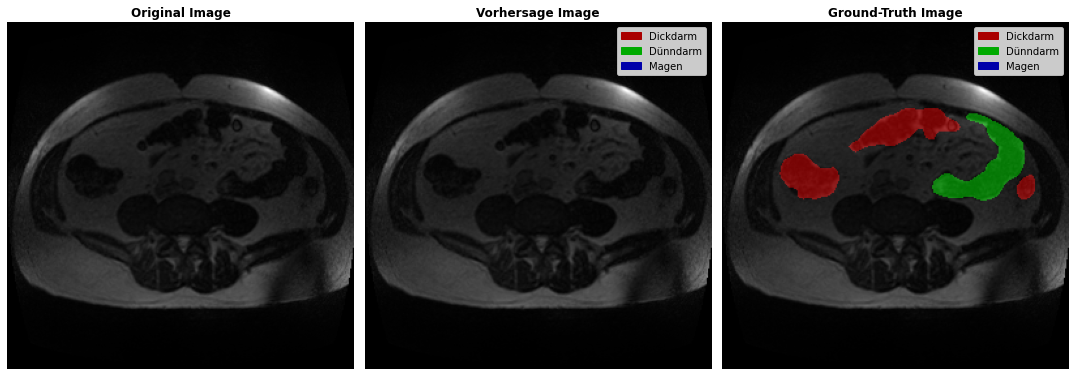

case40_day17_slice_0121
0.00045136132393955005
(266, 266, 3)


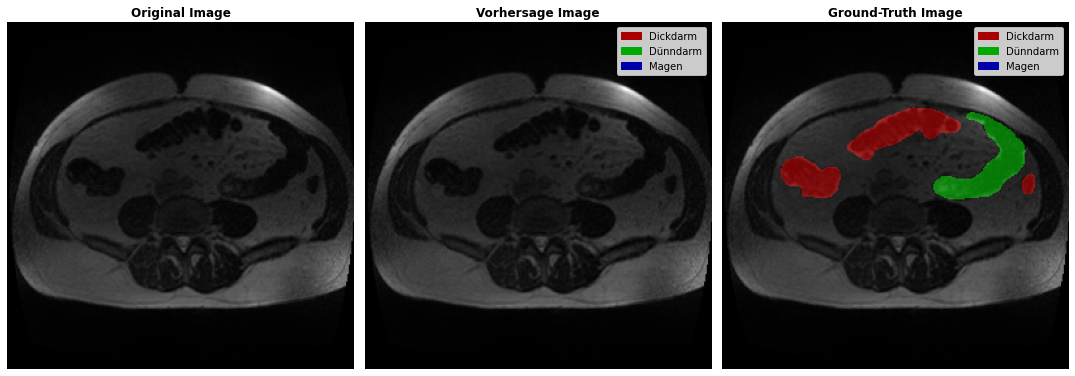

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


case49_day13_slice_0109
0.00045463854621625
(310, 360, 3)


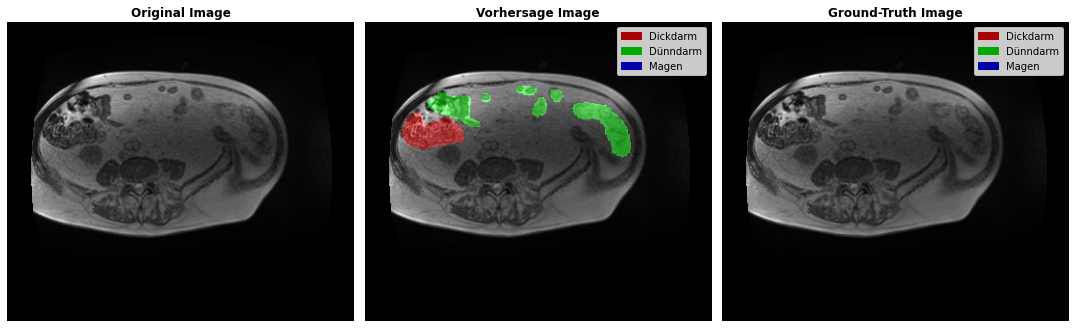

case40_day17_slice_0120
0.00046538434980895004
(266, 266, 3)


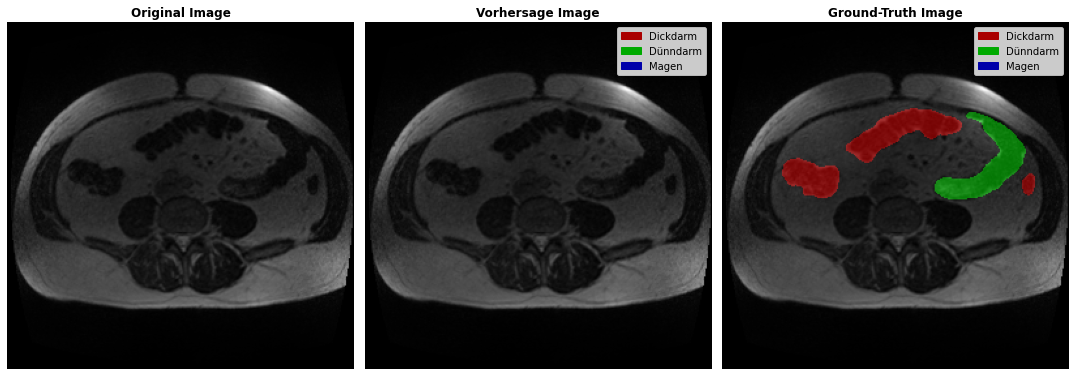

case40_day0_slice_0120
0.00049754540668795
(266, 266, 3)


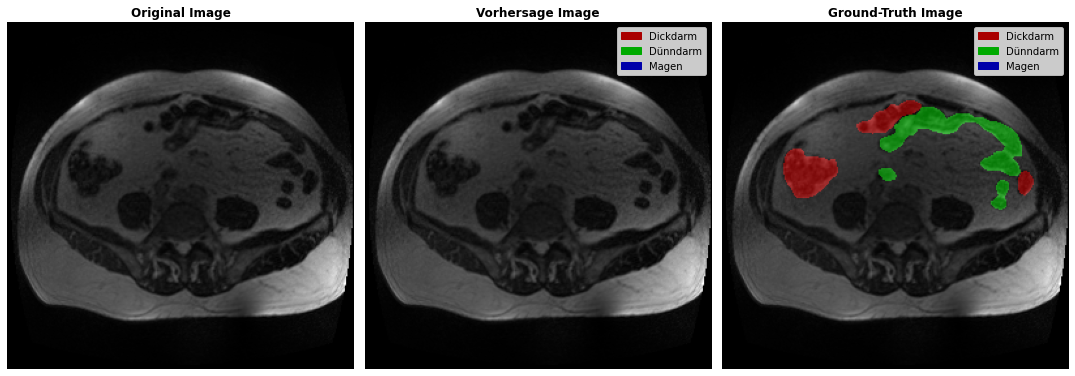

In [353]:
data = pd.read_csv("../tensorboard_logs/efb2/UNet_BB_efficientnetb2_DIM_(256, 256, 3)_SEMI3D_True_CROPDATA_True_FAULTIES_True_BATCH_16_EPOCHS_50_FOLD_3.h5_23082022-2114_FOLD_3/model.h5_val_results.csv")
df_val['dice_mean'] = df_val[['large_bowel_dice_coef','small_bowel_dice_coef','stomach_dice_coef']].mean(axis=1)

smallest =  df_val[df_val['dice_mean'] < 1].nsmallest(10, 'dice_mean')
for i in range(len(smallest)):
    ID = smallest['id'].values[i]
    
    print(ID)
    print(df_val[df_val['id'] == ID]['dice_mean'].values[0])
    
    img_path = df_val[df_val['id'] == ID]['path'].values[0]
    
    img = open_gray16(img_path, normalize=True, to_rgb=True)
    img = ((img-img.min())/(img.max()-img.min())).astype(np.float32)
    
    mask = get_id_mask(ID,df_train, verbose=False)
        
    pred = get_pred_mask(ID, df_val)
    
    print(pred.shape)
    #plot_original_mask(img, mask, alpha=0.6)
    plot_preds(img, pred, mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


case123_day20_slice_0073
(266, 266, 3)


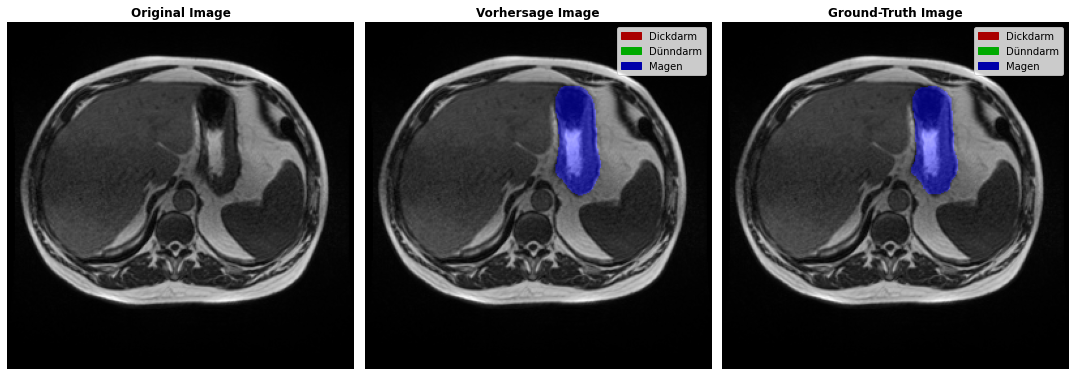

case36_day10_slice_0057
(266, 266, 3)


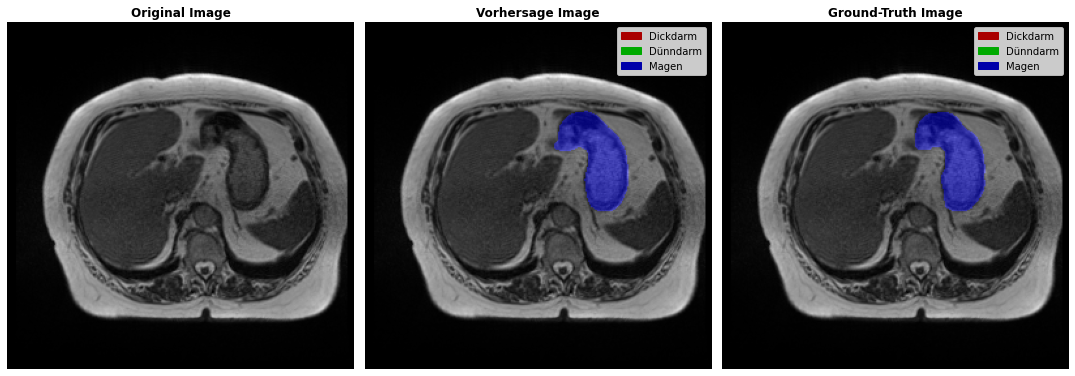

case36_day10_slice_0059
(266, 266, 3)


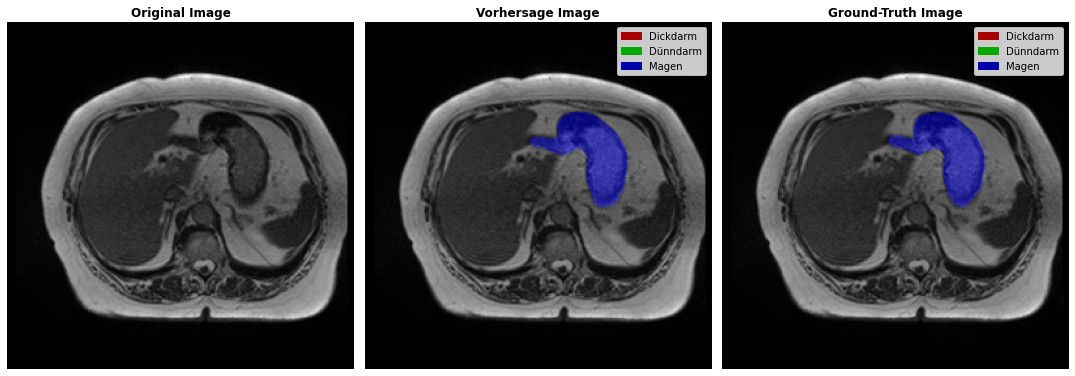

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


case123_day20_slice_0074
(266, 266, 3)


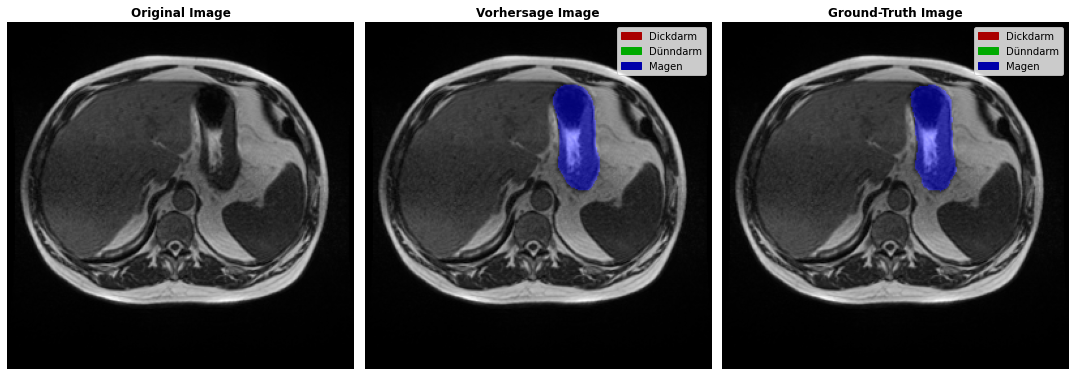

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


case123_day22_slice_0074
(266, 266, 3)


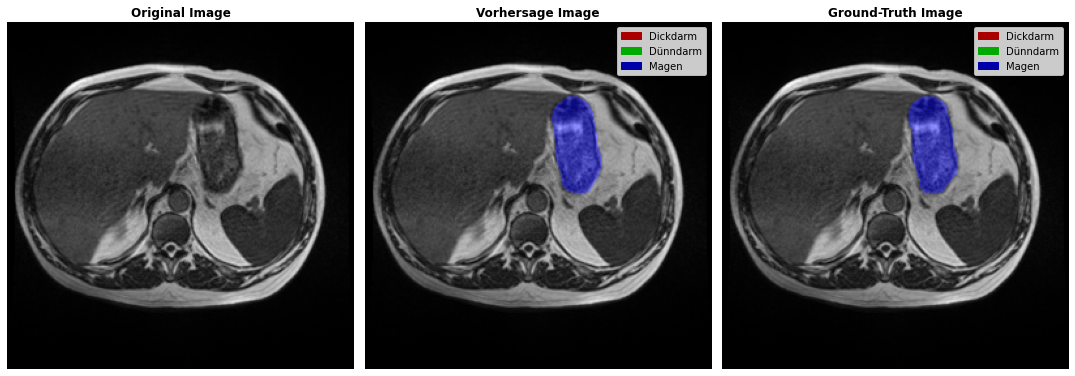

In [186]:
biggest =  df_val[df_val['dice_mean'] < 1].nlargest(5, 'dice_mean')

for i in range(len(biggest)):
    ID = biggest['id'].values[i]
    print(ID)
    
    img_path = df_val[df_val['id'] == ID]['path'].values[0]
    mask_path = df_val[df_val['id'] == ID]['multilabel_mask_path'].values[0]
    
    img = open_gray16(img_path, normalize=True, to_rgb=True)
    img = ((img-img.min())/(img.max()-img.min())).astype(np.float32)
    mask = get_id_mask(ID,df_train, verbose=False)
        
    pred = get_pred_mask(ID, df_val)
    
    print(pred.shape)
    #plot_original_mask(img, mask, alpha=0.6)
    plot_preds(img, pred, mask)